# Time Series Forecasting

In [1]:
"""
Time series forecasting е задача каде што предвидуваме идни вредности врз основа на временски подредени податоци (часови, денови, месеци, години). Клучно е што редоследот во времето е важен.

Каде се користи?
📈 Финансии: цени на акции, курсеви
🌦️ Време: температура, врнежи
🏭 Бизнис: продажба, побарувачка
⚡ Енергија: потрошувачка
🌐 IT: сообраќај на сервери

Типичен workflow
Exploratory Analysis (plot, тренд, сезоналност)
Preprocessing (missing values, scaling, differencing)
Feature engineering (lags, rolling mean)
Modeling
Evaluation (MAE, RMSE, MAPE)
Forecasting

❌ Никогаш не мешај идни податоци во тренинг
✅ Split по време, не random split
"""

'\nTime series forecasting е задача каде што предвидуваме идни вредности врз основа на временски подредени податоци (часови, денови, месеци, години). Клучно е што редоследот во времето е важен.\n\nКаде се користи?\n📈 Финансии: цени на акции, курсеви\n🌦️ Време: температура, врнежи\n🏭 Бизнис: продажба, побарувачка\n⚡ Енергија: потрошувачка\n🌐 IT: сообраќај на сервери\n\nТипичен workflow\nExploratory Analysis (plot, тренд, сезоналност)\nPreprocessing (missing values, scaling, differencing)\nFeature engineering (lags, rolling mean)\nModeling\nEvaluation (MAE, RMSE, MAPE)\nForecasting\n\n❌ Никогаш не мешај идни податоци во тренинг\n✅ Split по време, не random split\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv("data/09/bitstamp.csv")

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.40,4.40,4.37,4.38,2.898606,12.679597,4.37
1,1325317980,4.41,4.43,4.40,4.42,0.809277,3.587656,4.43
2,1325318040,4.40,4.42,4.40,4.41,0.699285,3.170613,4.53
3,1325318100,4.43,4.44,4.43,4.43,1.744751,7.858554,4.50
4,1325318160,4.51,4.51,4.51,4.51,2.943349,12.427913,4.22


We cast the `Timestamp` column into a `pd.Timestamp` object using the `pd.to_datetime`.

Note: We must specify the unit for the timestamp. The defaults is `ns`. 

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

Next, we set the `Timestamp` column as an index for the data frame and remove it as a column.

In [5]:
df.set_index(keys=["Timestamp"], drop=True, inplace=True)

We **always** sort the time series in an ascending order (from the past to the future).

In [6]:
df.sort_index(inplace=True)

We check for any missing values.

In [7]:
df.isnull().sum()

Open                 810
High                 810
Low                  810
Close                810
Volume_(BTC)         810
Volume_(Currency)    810
Weighted_Price       810
dtype: int64

We interpolate the missing values using a **linear interpolation**.
#Linear interpolation се користи за пополнување на missing вредности во time series

In [8]:
df.interpolate(inplace=True)

In [9]:
df.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

<Axes: >

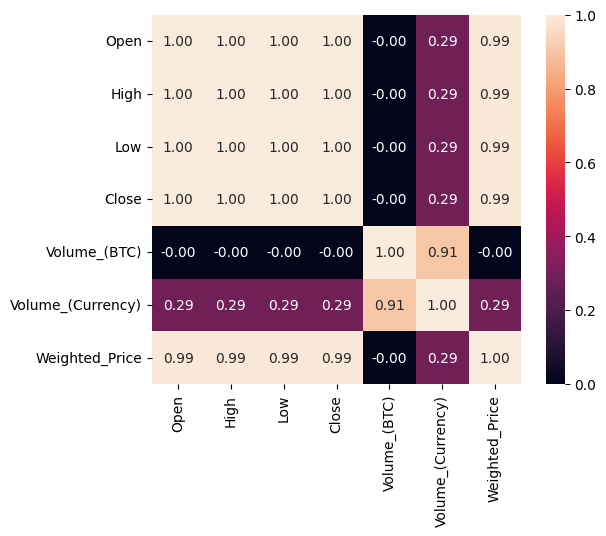

In [10]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", square=True)

In [3]:
#📌 Колку е бројот поблиску до 1 или −1, толку е посилна врската.
#Светло (бело/портокалово) → силна корелација
#Темно (црно/виолетово) → слаба или никаква корелација

In [11]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.40,4.40,4.37,4.38,2.898606,12.679597,4.37
2011-12-31 07:53:00,4.41,4.43,4.40,4.42,0.809277,3.587656,4.43
2011-12-31 07:54:00,4.40,4.42,4.40,4.41,0.699285,3.170613,4.53
2011-12-31 07:55:00,4.43,4.44,4.43,4.43,1.744751,7.858554,4.50
2011-12-31 07:56:00,4.51,4.51,4.51,4.51,2.943349,12.427913,4.22


A **univariate** time series is a sequence of observations collected over time from a single variable. It focuses on how that one variable changes over time.

A **multivariate** time series consists of observations collected over time from two or more variables, where the variables may influence each other.

Here, we'll focus on just one variable (`Close`), i.e., on a univariate time series. Nevertheless, the logic stays the same for a multivariate time series. 

In [12]:
df = df[["Close"]].copy(deep=True)

In [13]:
df.head()

,Close
Timestamp,
2011-12-31 07:52:00,4.38
2011-12-31 07:53:00,4.42
2011-12-31 07:54:00,4.41
2011-12-31 07:55:00,4.43
2011-12-31 07:56:00,4.51


Here, we define the **historical context (look-back window)** used to forecast the next `Close` price of BTC. This context represents the number of past observations (**lags**) that the model will rely on to predict the next future value.

In [14]:
lag = 3

In [15]:
periods = range(lag, 0, -1) # 3, 2, 1
"""
range(start, stop, step)
start = lag → почнува од lag (нпр. 3)
stop = 0 → не ја вклучува 0
step = -1 → се движи наназад

range(1, lag + 1)
➡️ исто ќе даде 1, 2, 3,
но нема „од минато → сегашност“ логика при итерација.


"""

In [16]:
list(periods)

[3, 2, 1]

When we feed the historical context into the model, the features must be sorted in **ascending temporal order**. This means the input should be structured so that the **oldest observations come first**, followed by the more recent ones, up to the **most recent past value**.

In other words, for each sample, **all variables** are ordered from the most distant past to the closest past (in a **univariate time series**, there's only one variable; in a **multivariate time series**, there are multiple variables).

In a **univariate time series** with the variable `Close` and 3 lags, the resulting data frame columns would be ordered from the most distant past to the most recent past: `Close_{t-3}`, `Close_{t-2}`, and `Close_{t-1}`. In a **multivariate time series** with variables such as `Close` and `Volume` using 3 lags, each lagged step contains all variables, producing columns in ascending temporal order as follows: `Close_{t-3}`, `Volume_{t-3}`, `Close_{t-2}`, `Volume_{t-2}`, `Close_{t-1}`, and `Volume_{t-1}`.

After organizing the data this way, we reshape it into the format: **(number of samples, number of time steps, number of features)**.

In [ ]:
#мора да бидат подредени по растечки временски редослед.

In [17]:
df.shift(periods)

,Close_3,Close_2,Close_1
Timestamp,,,
2011-12-31 07:52:00,NaN,NaN,NaN
2011-12-31 07:53:00,NaN,NaN,4.380
2011-12-31 07:54:00,NaN,4.380,4.420
2011-12-31 07:55:00,4.380,4.420,4.410
2011-12-31 07:56:00,4.420,4.410,4.430
...,...,...,...
2012-01-07 06:27:00,15.860,15.940,15.640
2012-01-07 06:28:00,15.940,15.640,15.830
2012-01-07 06:29:00,15.640,15.830,15.815


In [18]:
df = pd.concat([df, df.shift(periods=periods)], axis=1)

In [19]:
df.head()

,Close,Close_3,Close_2,Close_1
Timestamp,,,,
2011-12-31 07:52:00,4.38,NaN,NaN,NaN
2011-12-31 07:53:00,4.42,NaN,NaN,4.38
2011-12-31 07:54:00,4.41,NaN,4.38,4.42
2011-12-31 07:55:00,4.43,4.38,4.42,4.41
2011-12-31 07:56:00,4.51,4.42,4.41,4.43


When we create lagged features by shifting the data, we inevitably introduce missing values at the beginning of the series. Since these missing values represent time points for which no historical observations exist, they cannot be meaningfully imputed without introducing artificial information. For this reason, we simply drop the rows containing missing values.

In [20]:
df.dropna(inplace=True)     #Ги брише сите редови во df што содржат NaN (missing) вредности

In [21]:
df.head()

,Close,Close_3,Close_2,Close_1
Timestamp,,,,
2011-12-31 07:55:00,4.43,4.38,4.42,4.41
2011-12-31 07:56:00,4.51,4.42,4.41,4.43
2011-12-31 07:57:00,4.48,4.41,4.43,4.51
2011-12-31 07:58:00,4.48,4.43,4.51,4.48
2011-12-31 07:59:00,4.54,4.51,4.48,4.48


In [22]:
X, y = df.drop(columns=["Close"]), df[["Close"]]           #split

In [23]:
X

,Close_3,Close_2,Close_1
Timestamp,,,
2011-12-31 07:55:00,4.380,4.420,4.410
2011-12-31 07:56:00,4.420,4.410,4.430
2011-12-31 07:57:00,4.410,4.430,4.510
2011-12-31 07:58:00,4.430,4.510,4.480
2011-12-31 07:59:00,4.510,4.480,4.480
...,...,...,...
2012-01-07 06:27:00,15.860,15.940,15.640
2012-01-07 06:28:00,15.940,15.640,15.830
2012-01-07 06:29:00,15.640,15.830,15.815


In [24]:
y

,Close
Timestamp,
2011-12-31 07:55:00,4.430
2011-12-31 07:56:00,4.510
2011-12-31 07:57:00,4.480
2011-12-31 07:58:00,4.480
2011-12-31 07:59:00,4.540
...,...
2012-01-07 06:27:00,15.830
2012-01-07 06:28:00,15.815
2012-01-07 06:29:00,15.800


We **never** shuffle a time series.

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, shuffle=False)

In [26]:
init_train_X, init_train_y = train_X.copy(), train_y.copy()
init_val_X, init_val_y = val_X.copy(), val_y.copy()
init_test_X, init_test_y = test_X.copy(), test_y.copy()

In [27]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)

In [28]:
train_X.shape       #(број на примероци,број на карактеристики)

(6397, 3)

In [29]:
(train_X.shape[0], lag, (train_X.shape[1] // lag)) # (samples, timesteps, features)

#Оваа структура ги дефинира димензиите потребни за LSTM/RNN модел: број на примероци, број на временски чекори и број на карактеристики по чекор.

(6397, 3, 1)

In [30]:
train_X = train_X.reshape(train_X.shape[0], lag, (train_X.shape[1] // lag))
val_X = val_X.reshape(val_X.shape[0], lag, (val_X.shape[1] // lag))
test_X = test_X.reshape(test_X.shape[0], lag, (test_X.shape[1] // lag))


#Овие линии ги reshаpираат влезните податоци од 2D во 3D формат потребен за RNN/LSTM модели:
#samples = број на примероци

#timesteps = lag (колку минати чекори гледа моделот)

#features_per_timestep = број на променливи по чекор

#➡️ Со ова моделот ја добива временската структура на податоците (минато → сегашност).

In [31]:
(train_X.shape[1], train_X.shape[2])   #Ова најчесто оди како input_shape кај LSTM/RNN:

(3, 1)

In [32]:
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)
device

#Кодот автоматски го избира најдобриот достапен уред за извршување на моделот.

'cpu'

In [33]:
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32)

val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y.to_numpy(), dtype=torch.float32)

test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32)

#Овој код ги конвертира податоците во PyTorch тензори со тип float32, што е потребно за тренирање на модел.

In [34]:
print(train_X.shape, val_X.shape, test_X.shape)

torch.Size([6397, 3, 1]) torch.Size([1600, 3, 1]) torch.Size([2000, 3, 1])


In [35]:
print(train_y.shape, val_y.shape, test_y.shape)   #➡️ Ги печати димензиите (shape) на таргет променливата y за:

torch.Size([6397, 1]) torch.Size([1600, 1]) torch.Size([2000, 1])


In [36]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

"""
Овие линии ги спојуваат влезовите и таргетите во PyTorch Dataset објекти:

train_dataset → (train_X, train_y)

val_dataset → (val_X, val_y)

test_dataset → (test_X, test_y)

➡️ TensorDataset овозможува секој примерок да се земе како пар (X, y), што е неопходно за користење со DataLoader при тренирање, валидација и тестирање на моделот.
"""

In [37]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


"""
Овој код креира DataLoader-и за тренинг, валидација и тест:

batch_size=32 → податоците се земаат во мини-батчеви од 32 примероци

shuffle=False → не се меша редоследот (многу важно кај time series)

➡️ DataLoader овозможува ефикасно итерирање низ податоците при тренирање и евалуација на моделот.

Испитна реченица:

DataLoader ги дели податоците на батчеви и го зачувува временскиот редослед, што е клучно за временски серии.
"""

In [ ]:
"""
Не, сè уште не е целосно решена задачата.
Ова што го направи досега е подготовка на податоците ✔️

Што ИМАШ направено (и е точно):

✅ lag features
✅ reshape во (samples, timesteps, features)
✅ train / val / test split (без shuffle)
✅ конверзија во PyTorch tensors
✅ TensorDataset + DataLoader

➡️ Ова е целиот preprocessing pipeline за time series со LSTM.

Што НЕДОСТАСУВА за да е „решена“:

❌ LSTM модел
❌ loss function (нпр. MSELoss)
❌ optimizer (Adam)
❌ training loop
❌ evaluation на test set
"""

## CNN Time-Series Forecaster

The CNN architecture is well-suited for time series forecasting because its 1D convolutional layers can efficiently capture short-term temporal patterns, such as trends or spikes, within the historical context, while sharing weights across time to reduce the number of parameters and improve generalization. It also benefits from parallel computation and the ability to detect multiple patterns simultaneously with different convolution filters. However, CNNs have limitations for time series: their receptive field is fixed by the kernel size and network depth, making it difficult to capture long-term dependencies or trends beyond the input window. They treat sequences more like spatial data than inherently sequential data, so temporal order is only indirectly accounted for, and with many input variables, the network may require more filters and parameters, increasing computational cost. Overall, this architecture is good at modeling short-term dependencies efficiently but may struggle with long-term relationships in the data, requiring careful tuning of kernel sizes, filters, and layers.

In [38]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) # (samples, timesteps, features) -> (samples, features, timesteps)
        return self.net(x)

In [39]:
model = CNNRegressor().to(device)
model

CNNRegressor(
  (net): Sequential(
    (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [40]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [41]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()

    total_loss = 0
    for features, targets in dataloader:
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(features)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss

In [42]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()

    total_loss, predictions = 0, []
    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features.to(device), targets.to(device)

            outputs = model(features)
            loss = loss_fn(outputs, targets)

            predictions.extend(outputs.squeeze(1).tolist())
            
            total_loss += loss.item()

    return total_loss, predictions

In [43]:
num_epochs = 16

In [44]:
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_loss)
        val_loss, pred_y = evaluate(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)

        mape = mean_absolute_percentage_error(val_y.tolist(), pred_y)

        if epoch % 2 == 0:
            print(f"Epoch {epoch:3d}/{num_epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} mape={mape:.4f}")
    
    return train_losses, val_losses

In [45]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs)

Epoch   2/16 | train_loss=1526.1717 val_loss=62.0999 mape=0.1117
Epoch   4/16 | train_loss=285.3508 val_loss=20.7681 mape=0.0641
Epoch   6/16 | train_loss=103.0601 val_loss=7.1476 mape=0.0369
Epoch   8/16 | train_loss=43.4753 val_loss=2.4809 mape=0.0218
Epoch  10/16 | train_loss=18.2323 val_loss=0.6950 mape=0.0110
Epoch  12/16 | train_loss=7.9911 val_loss=1.1249 mape=0.0145
Epoch  14/16 | train_loss=6.7193 val_loss=0.7240 mape=0.0113
Epoch  16/16 | train_loss=6.9747 val_loss=0.6425 mape=0.0107


<Axes: >

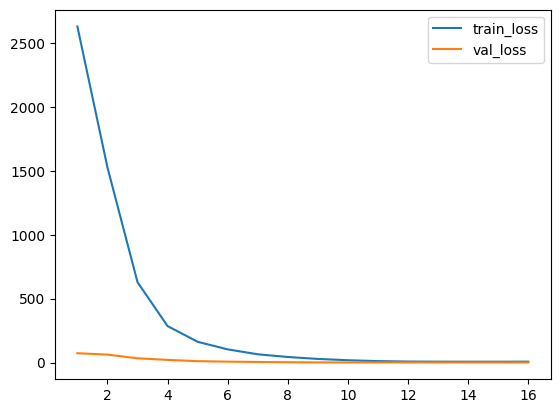

In [46]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [47]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn, device)

Here, we define a baseline model that uses the observation from one time step in the past (`Close_1`) as a predictor for the target value (`Close`) and then evaluate its performance.

In [48]:
print(f"MAE: {mean_absolute_error(test_y, init_test_X['Close_1'])}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, init_test_X['Close_1'])}")
print(f"MSE: {mean_squared_error(test_y, init_test_X['Close_1'])}")
print(f"RMSE: {root_mean_squared_error(test_y, init_test_X['Close_1'])}")
print(f"R2 Score: {r2_score(test_y, init_test_X['Close_1'])}")

MAE: 0.11162001180648803
MAPE: 0.007898543230299806
MSE: 0.0200752090665361
RMSE: 0.14168701093091102
R2 Score: 0.9967020388840754


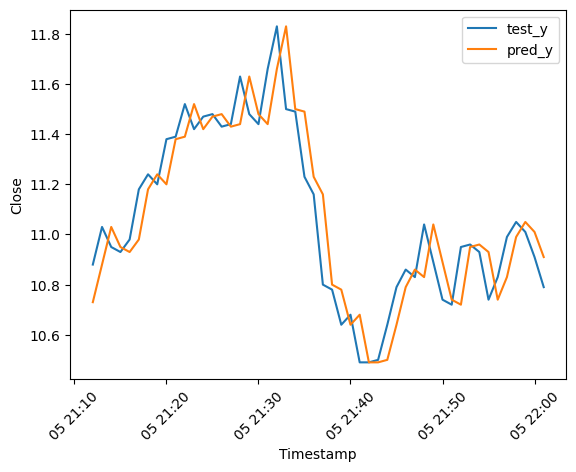

In [61]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=init_test_X["Close_1"][:50], label="pred_y")
plt.xticks(rotation=45);

Here, we evaluate the performance of the CNN model.

In [50]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 0.28924064826965334
MAPE: 0.019111578525741652
MSE: 0.12747126748166102
RMSE: 0.35703118558700303
R2 Score: 0.9790589835374159


In [ ]:
"""
prvoto mae e beseline a  второто е моделот.
📌 Ако твојот модел НЕ е подобар од ова (baseline)→ моделот е бескорисен.
Првиот сет метрики ја мери наивната прогноза базирана на последната позната вредност, а вториот сет ја мери точноста на обучениот модел.
pred_y е излез од обучен CNN или LSTM модел, додека Close_1 претставува наивна baseline прогноза.

Кога да користиш LSTM ✅

Долгорочни зависности (што се случило пред многу чекори)

Помал dataset

Кога редоследот е критичен

Пример: финансиски серии, трендови, зависности низ време

Испитна реченица:

LSTM е погоден за моделирање на долгорочни временски зависности.

Кога да користиш CNN ✅

Локални обрасци (кратки периоди)

Голем dataset

Потребна е брзина

Пример: сензорски податоци, краткорочни флуктуации

Испитна реченица:

CNN извлекува локални временски обрасци преку конволуции.

Брза споредба 📊
Карактеристика	LSTM	CNN
Долгорочна меморија	✔️	❌
Брзина	❌	✔️
Паралелизација	❌	✔️
Склон кон overfitting	Помал	Поголем
Реален совет (без филозофија)

Почни со baseline

Потоа CNN

Ако CNN не фаќа долг контекст → LSTM

1 реченица за професор 🎯

CNN е добар за локални временски обрасци, а LSTM за долгорочни зависности во временски серии.

Ако сакаш, можам да ти кажам што професор најчесто очекува на колоквиум или да ти помогнам да избереш што да пишеш како одговор.

| Карактеристика        | LSTM  | CNN     |
| --------------------- | ----- | ------- |
| Долгорочна меморија   | ✔️    | ❌       |
| Брзина                | ❌     | ✔️      |
| Паралелизација        | ❌     | ✔️      |
| Склон кон overfitting | Помал | Поголем |

kripto za lstm
За проект / испит → LSTM (полесно се оправдува теоретски)

За брз benchmark → CNN

За најдобар резултат → CNN + LSTM

"""

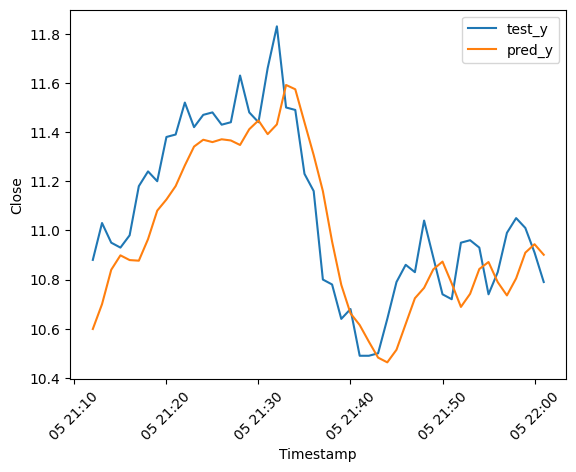

In [51]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=pred_y[:50], label="pred_y")
plt.xticks(rotation=45);

## LSTM Time-Series Forecaster

The LSTM architecture is well-suited for time series forecasting because it inherently models the temporal order of the data and can capture long-term dependencies, making it effective for sequences with trends or patterns that span many time steps. The stacked LSTM layers allow the network to learn progressively more complex temporal features, and it can handle variable-length input sequences without needing fixed-size windows. However, LSTMs are generally slower to train than CNNs due to their sequential processing, and they typically have more parameters, which can increase the risk of overfitting on smaller datasets. Additionally, while LSTMs mitigate the vanishing gradient problem compared to vanilla RNNs, they may still struggle with extremely long sequences, and careful tuning of hyperparameters such as hidden size, number of layers, learning rate, and sequence length is required for optimal performance.

![](images/09/lstm.png)

In [52]:
class LSTMRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=16, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=16, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        return self.fc(x)

In [53]:
model = LSTMRegressor().to(device)
model

LSTMRegressor(
  (lstm1): LSTM(1, 16, batch_first=True)
  (lstm2): LSTM(16, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [54]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [55]:
num_epochs = 32

In [56]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs)

Epoch   2/32 | train_loss=9832.5208 val_loss=46.9948 mape=0.0872
Epoch   4/32 | train_loss=4471.0690 val_loss=272.8049 mape=0.2709
Epoch   6/32 | train_loss=2074.8555 val_loss=35.6270 mape=0.0965
Epoch   8/32 | train_loss=930.3816 val_loss=0.7791 mape=0.0116
Epoch  10/32 | train_loss=485.3021 val_loss=0.9041 mape=0.0128
Epoch  12/32 | train_loss=281.7354 val_loss=2.3824 mape=0.0218
Epoch  14/32 | train_loss=193.0812 val_loss=5.2989 mape=0.0340
Epoch  16/32 | train_loss=159.9238 val_loss=7.3493 mape=0.0402
Epoch  18/32 | train_loss=145.0365 val_loss=6.8817 mape=0.0384
Epoch  20/32 | train_loss=115.4370 val_loss=5.0324 mape=0.0325
Epoch  22/32 | train_loss=78.0007 val_loss=3.3804 mape=0.0268
Epoch  24/32 | train_loss=51.4927 val_loss=1.9266 mape=0.0201
Epoch  26/32 | train_loss=36.7357 val_loss=1.1305 mape=0.0149
Epoch  28/32 | train_loss=29.2884 val_loss=0.8810 mape=0.0129
Epoch  30/32 | train_loss=23.9490 val_loss=0.7014 mape=0.0113
Epoch  32/32 | train_loss=19.5211 val_loss=0.6046 map

In [57]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn, device)

<Axes: >

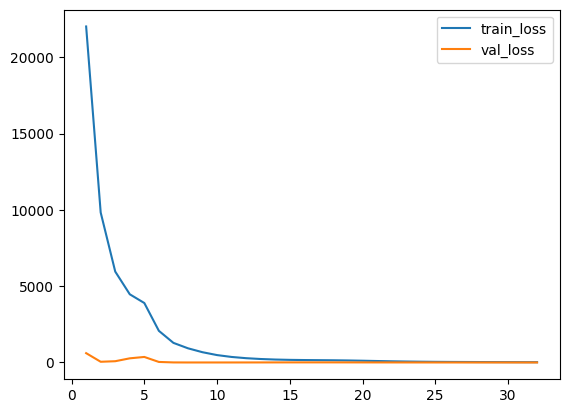

In [58]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

Here, we evaluate the performance of the LSTM model.

In [59]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 0.21165279245376586
MAPE: 0.014293262956646792
MSE: 0.07239484192308328
RMSE: 0.2690628958498055
R2 Score: 0.9881069545595005


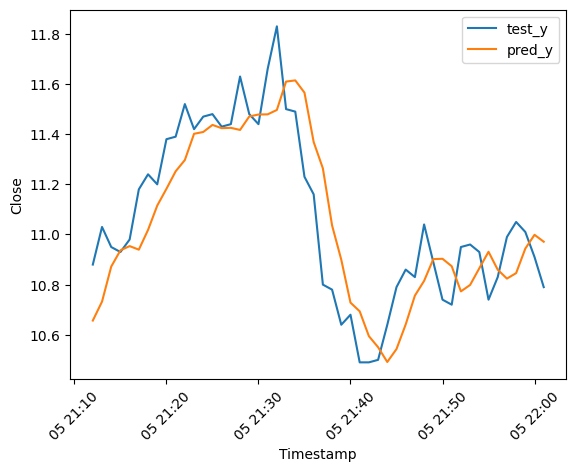

In [60]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=pred_y[:50], label="pred_y")
plt.xticks(rotation=45);